In [48]:
import xarray as xr
import flox.xarray as fx
import numpy as np
import pandas as pd
import cmocean.cm as cmo
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.ticker as ticker

In [2]:
import oceanmixedlayers as oml

In [3]:
ds_globe = xr.open_dataset('/swot/SUM05/amf2288/sync-boxes/new_test.nc', chunks={'N_PROF':10000})

In [4]:
unique_prof = np.arange(len(ds_globe['N_PROF']))
ds_globe = ds_globe.assign_coords(N_PROF=('N_PROF', unique_prof))
ds_so = ds_globe.where(ds_globe.LATITUDE.compute()<-30, drop=True)

In [5]:
def get_ds_binned(ds, lon_bins, lat_bins):
    """
    Bin an xarray Dataset by 3-degree latitude and longitude bins,
    replacing Interval dimensions with bin centers.
    
    Parameters:
        ds : xarray.Dataset
            The dataset to bin.
        lon_bins : array-like
            Bin edges for longitude (e.g. np.arange(-180, 181, 3))
        lat_bins : array-like
            Bin edges for latitude (e.g. np.arange(-90, 91, 3))
    
    Returns:
        xarray.Dataset
            Binned dataset with dimensions (PRES_INTERPOLATED, lon_c, lat_c)
    """

    # Step 1: Bin with fx.xarray_reduce using IntervalIndex
    ds_binned = fx.xarray_reduce(
        ds,
        'LONGITUDE',
        'LATITUDE',
        func='mean',
        expected_groups=(
            pd.IntervalIndex.from_breaks(lon_bins),
            pd.IntervalIndex.from_breaks(lat_bins),
        ),
        fill_value=np.nan,
        skipna=True
    )

    # Step 2: Create left, right, center arrays
    lon_l = np.array(lon_bins[:-1])
    lon_r = np.array(lon_bins[1:])
    lon_c = (lon_l + lon_r) / 2

    lat_l = np.array(lat_bins[:-1])
    lat_r = np.array(lat_bins[1:])
    lat_c = (lat_l + lat_r) / 2

    # Step 3: Replace Interval dims with center dims
    ds_binned = ds_binned.assign_coords({
        "lon_c": ("LONGITUDE", [iv.mid for iv in ds_binned['LONGITUDE'].values]),
        "lat_c": ("LATITUDE", [iv.mid for iv in ds_binned['LATITUDE'].values]),
        "lon_l": ("LONGITUDE", lon_l),
        "lon_r": ("LONGITUDE", lon_r),
        "lat_l": ("LATITUDE", lat_l),
        "lat_r": ("LATITUDE", lat_r),
    })

    ds_binned = ds_binned.swap_dims({"LONGITUDE": "lon_c", "LATITUDE": "lat_c"})

    return ds_binned

In [69]:
lon_bins = np.arange(-180.5,181.5,1)
so_lat_bins = np.arange(-90.5,-28.5,1)

In [70]:
seasonal_groups = ds_so.groupby('TIME.season')

ds_so_binned_seasonal = {
    season: get_ds_binned(group, lon_bins, so_lat_bins)
    for season, group in seasonal_groups
}


In [75]:
ordered_seasons = ["DJF", "MAM", "JJA", "SON"]
season_labels = {
    "DJF": "Summer",
    "MAM": "Autumn",
    "JJA": "Winter",
    "SON": "Spring"
}

In [11]:
sel_lon = 120
aus_seasonal_binned = {}

for season, ds in ds_so_binned_seasonal.items():
    aus_seasonal_binned[season] = ds.sel(lon_c=sel_lon, method='nearest')[['SA', 'CT', 'SIG0']].compute()
    print(f"Finished processing {season}")

Finished processing DJF
Finished processing JJA
Finished processing MAM
Finished processing SON


/tmp/ipykernel_48757/2901701317.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


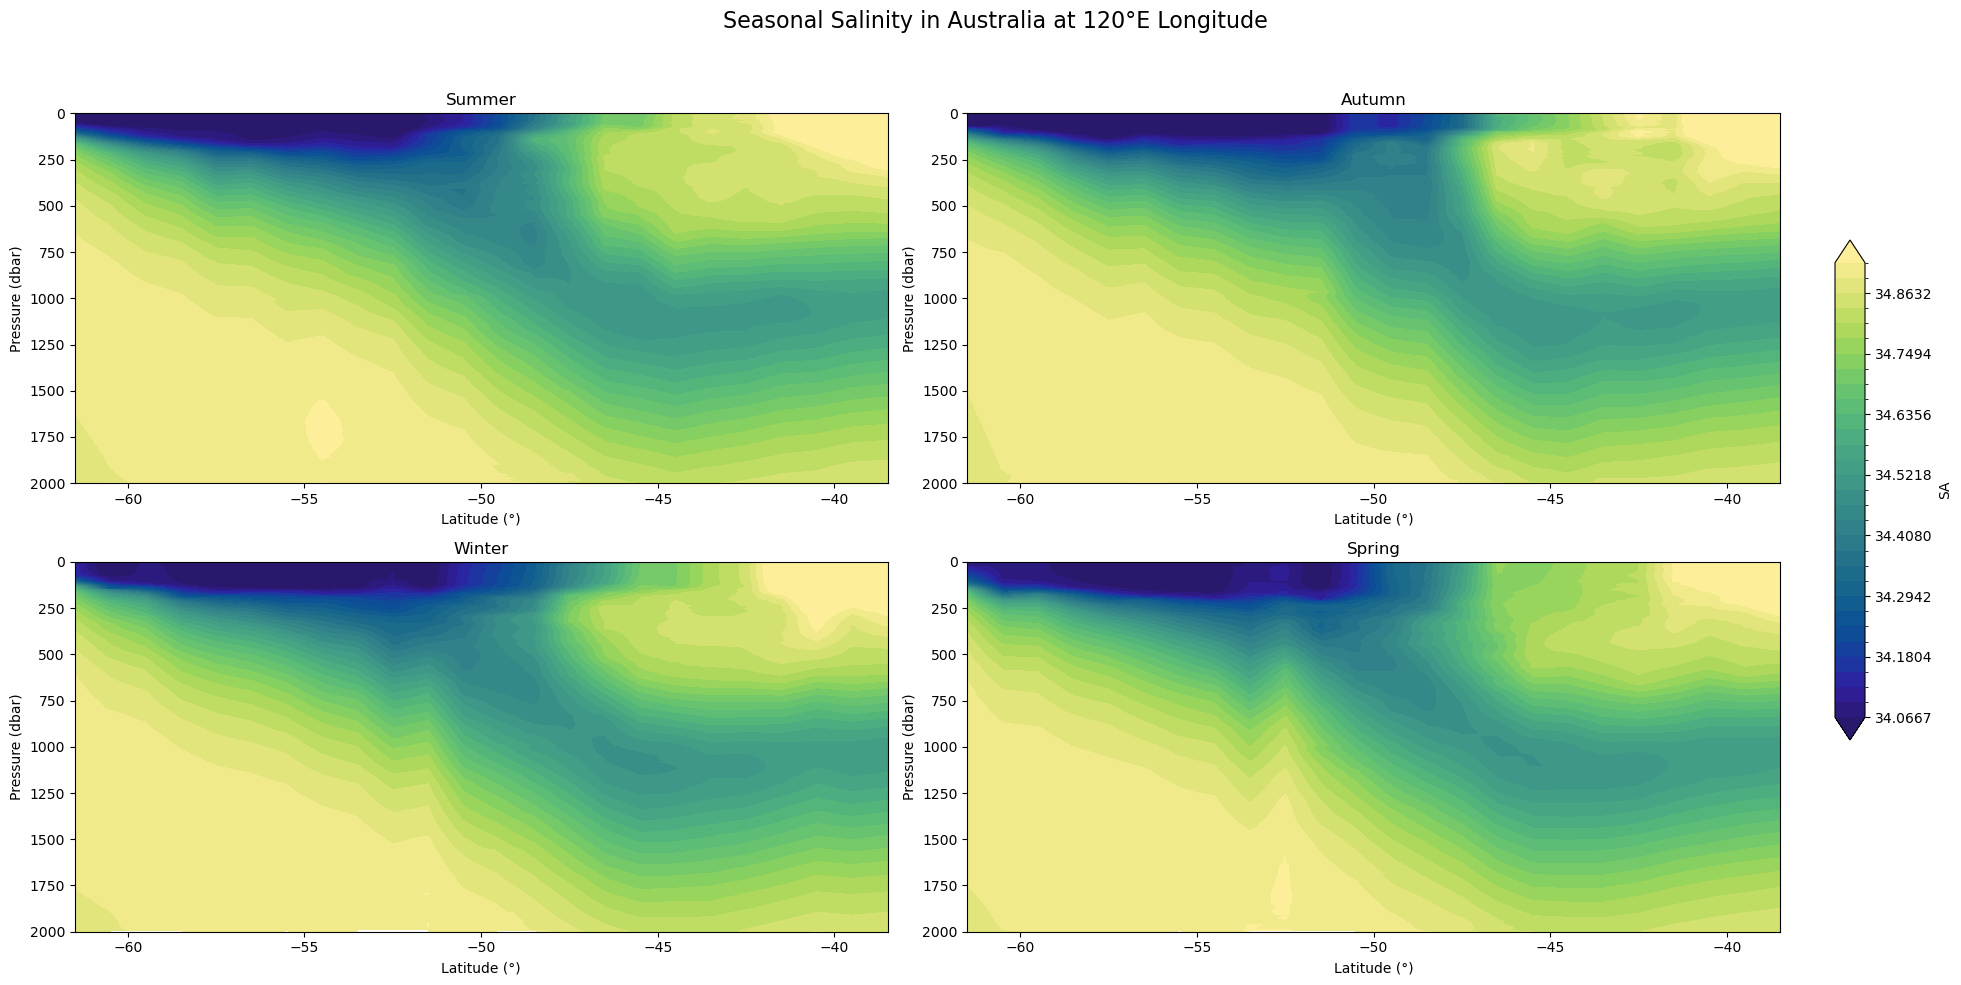

In [62]:
# Clip and prepare anomalies
seasonal_SA_sections = {
    season: ds.SA.sel(lat_c=slice(-65, -38), PRES_INTERPOLATED=slice(0, 1000))
    for season, ds in aus_seasonal_binned.items()
}

# Get global vmin/vmax for consistent color scale
all_SA = xr.concat([da for da in seasonal_SA_sections.values()], dim='season')
vmin = float(all_SA.quantile(0.02))
vmax = float(all_SA.quantile(0.98))
levels = np.linspace(vmin, vmax, 31)

# Plot
fig, axs = plt.subplots(2, 2, figsize=(20, 10))
axs = axs.ravel()

for i, season in enumerate(ordered_seasons):  # Make sure ordered_seasons is defined like ['DJF', 'MAM', 'JJA', 'SON']
    da = seasonal_SA_sections[season]
    ax = axs[i]
    
    contour = da.plot.contourf(
        ax=ax,
        x='lat_c',
        y='PRES_INTERPOLATED',
        yincrease=False,
        cmap=cmo.haline,
        vmin=vmin,
        vmax=vmax,
        levels=31,
        add_colorbar=False
    )
    
    ax.axvline(0, color='grey', linestyle='--', linewidth=1)
    ax.set_xlim(-61.5, -38.5)
    ax.set_title(season_labels[season])  # make sure season_labels is defined
    ax.set_xlabel("Latitude (°)")
    ax.set_ylabel("Pressure (dbar)")

# Shared colorbar
cbar_ax = fig.add_axes([0.92, 0.25, 0.015, 0.5])
plt.colorbar(contour, cax=cbar_ax, label="SA")

plt.suptitle("Seasonal Salinity in Australia at 120°E Longitude", fontsize=16)
plt.tight_layout(rect=[0, 0, 0.9, 0.95])
plt.show()


/tmp/ipykernel_48757/3190435056.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


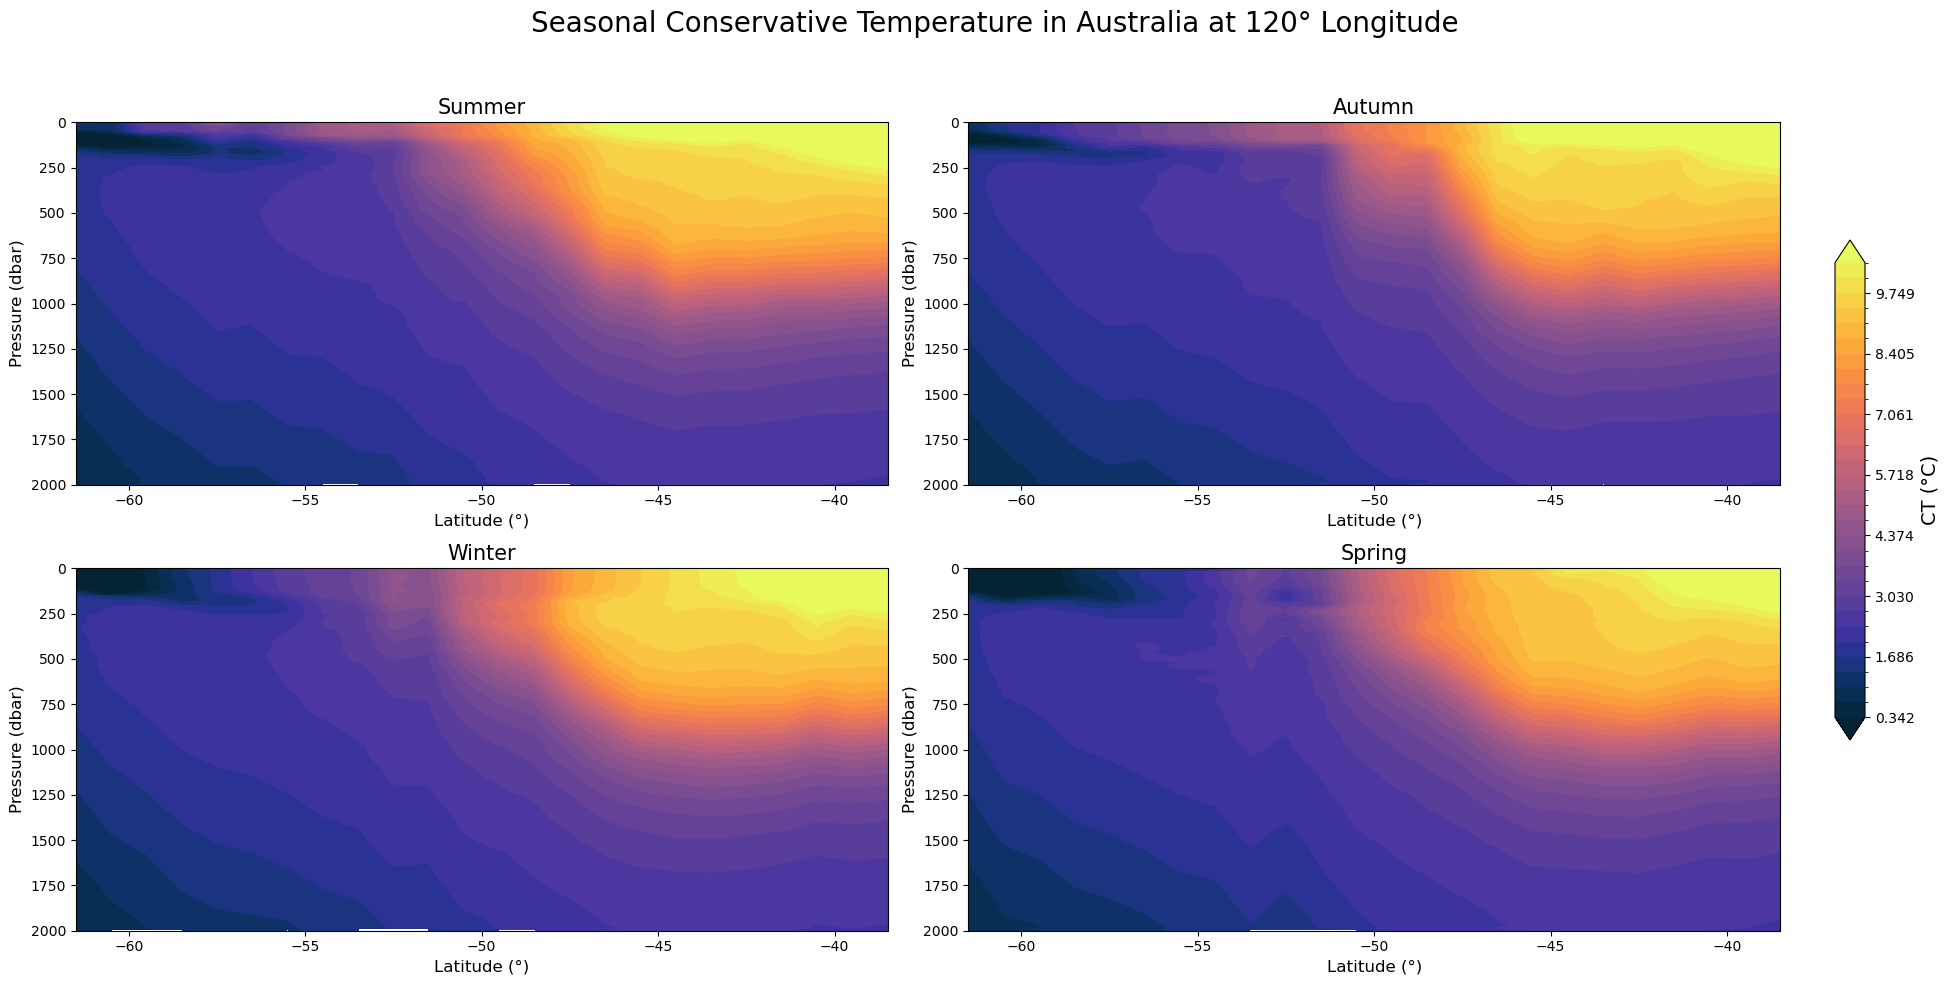

In [61]:
# Clip and prepare anomalies
seasonal_CT_sections = {
    season: ds.CT.sel(lat_c=slice(-65, -38), PRES_INTERPOLATED=slice(0, 2000))
    for season, ds in aus_seasonal_binned.items()
}

# Get global vmin/vmax for consistent color scale
all_CT = xr.concat([da for da in seasonal_CT_sections.values()], dim='season')
vmin = float(all_CT.quantile(0.02))
vmax = float(all_CT.quantile(0.98))
levels = np.linspace(vmin, vmax, 31)

# Plot
fig, axs = plt.subplots(2, 2, figsize=(20, 10))
axs = axs.ravel()

for i, season in enumerate(ordered_seasons):  # Make sure ordered_seasons is defined like ['DJF', 'MAM', 'JJA', 'SON']
    da = seasonal_CT_sections[season]
    ax = axs[i]
    
    contour = da.plot.contourf(
        ax=ax,
        x='lat_c',
        y='PRES_INTERPOLATED',
        yincrease=False,
        cmap=cmo.thermal,
        vmin=vmin,
        vmax=vmax,
        levels=31,
        add_colorbar=False
    )
    
    ax.axvline(0, color='grey', linestyle='--', linewidth=1)
    ax.set_xlim(-61.5, -38.5)
    ax.set_title(season_labels[season], fontsize = 15)  # make sure season_labels is defined
    ax.set_xlabel("Latitude (°)", fontsize = 12)
    ax.set_ylabel("Pressure (dbar)", fontsize = 12)

# Shared colorbar
cbar_ax = fig.add_axes([0.92, 0.25, 0.015, 0.5])
cbar = plt.colorbar(contour, cax=cbar_ax)
cbar.set_label("CT (°C)", fontsize=14)

plt.suptitle("Seasonal Conservative Temperature in Australia at 120° Longitude", fontsize=20)
plt.tight_layout(rect=[0, 0, 0.9, 0.95])
plt.show()


/tmp/ipykernel_48757/292361682.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


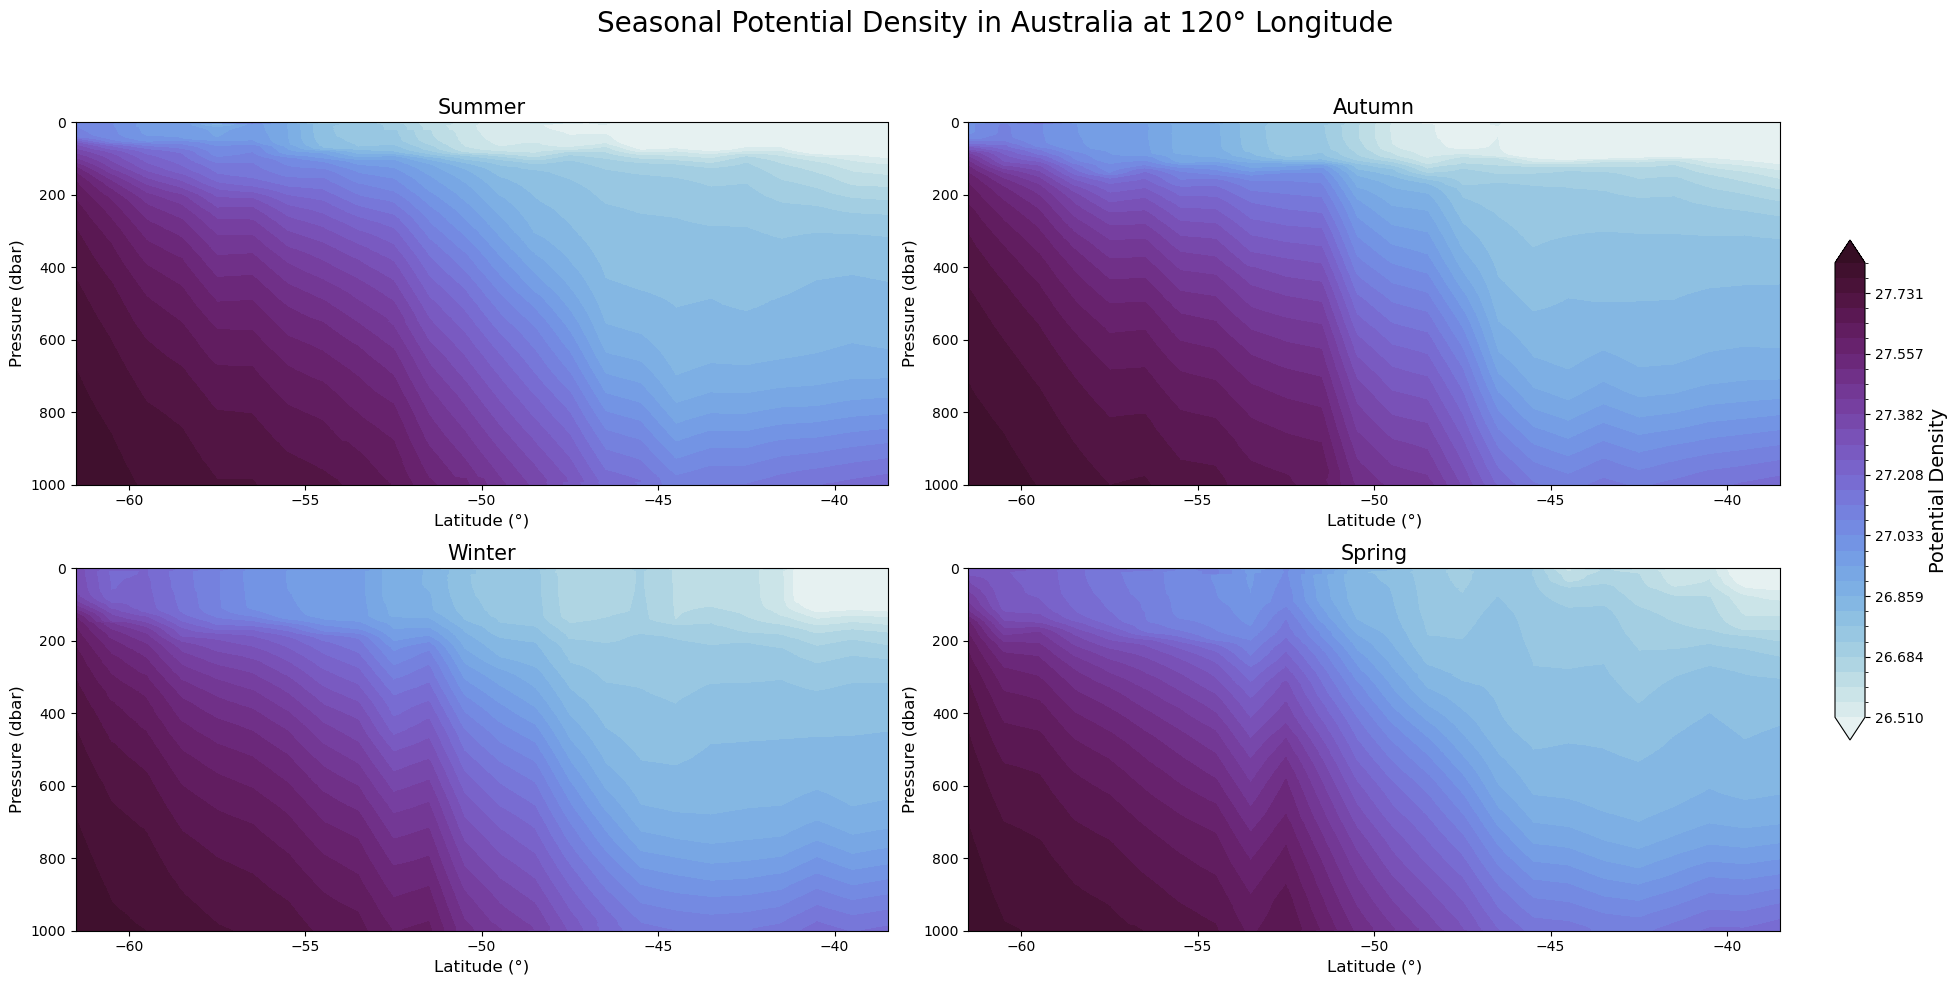

In [59]:
# Clip and prepare anomalies
seasonal_SIG0_sections = {
    season: ds.SIG0.sel(lat_c=slice(-65, -38), PRES_INTERPOLATED=slice(0, 1000))
    for season, ds in aus_seasonal_binned.items()
}

# Get global vmin/vmax for consistent color scale
all_SIG0 = xr.concat([da for da in seasonal_SIG0_sections.values()], dim='season')
vmin = float(all_SIG0.quantile(0.02))
vmax = float(all_SIG0.quantile(0.98))
levels = np.linspace(vmin, vmax, 31)

# Plot
fig, axs = plt.subplots(2, 2, figsize=(20, 10))
axs = axs.ravel()

for i, season in enumerate(ordered_seasons):  # Make sure ordered_seasons is defined like ['DJF', 'MAM', 'JJA', 'SON']
    da = seasonal_SIG0_sections[season]
    ax = axs[i]
    
    contour = da.plot.contourf(
        ax=ax,
        x='lat_c',
        y='PRES_INTERPOLATED',
        yincrease=False,
        cmap=cmo.dense,
        vmin=vmin,
        vmax=vmax,
        levels=31,
        add_colorbar=False
    )
    
    ax.axvline(0, color='grey', linestyle='--', linewidth=1)
    ax.set_xlim(-61.5, -38.5)
    ax.set_title(season_labels[season], fontsize = 15)  # make sure season_labels is defined
    ax.set_xlabel("Latitude (°)", fontsize = 12)
    ax.set_ylabel("Pressure (dbar)", fontsize = 12)

# Shared colorbar
cbar_ax = fig.add_axes([0.92, 0.25, 0.015, 0.5])
cbar = plt.colorbar(contour, cax=cbar_ax)
cbar.set_label("Potential Density", fontsize=14)

plt.suptitle("Seasonal Potential Density in Australia at 120° Longitude", fontsize=20)
plt.tight_layout(rect=[0, 0, 0.9, 0.95])
plt.show()


In [68]:
ds_so_binned_seasonal['DJF']['lon_c'].values

array([-179.5, -178.5, -177.5, -176.5, -175.5, -174.5, -173.5, -172.5,
       -171.5, -170.5, -169.5, -168.5, -167.5, -166.5, -165.5, -164.5,
       -163.5, -162.5, -161.5, -160.5, -159.5, -158.5, -157.5, -156.5,
       -155.5, -154.5, -153.5, -152.5, -151.5, -150.5, -149.5, -148.5,
       -147.5, -146.5, -145.5, -144.5, -143.5, -142.5, -141.5, -140.5,
       -139.5, -138.5, -137.5, -136.5, -135.5, -134.5, -133.5, -132.5,
       -131.5, -130.5, -129.5, -128.5, -127.5, -126.5, -125.5, -124.5,
       -123.5, -122.5, -121.5, -120.5, -119.5, -118.5, -117.5, -116.5,
       -115.5, -114.5, -113.5, -112.5, -111.5, -110.5, -109.5, -108.5,
       -107.5, -106.5, -105.5, -104.5, -103.5, -102.5, -101.5, -100.5,
        -99.5,  -98.5,  -97.5,  -96.5,  -95.5,  -94.5,  -93.5,  -92.5,
        -91.5,  -90.5,  -89.5,  -88.5,  -87.5,  -86.5,  -85.5,  -84.5,
        -83.5,  -82.5,  -81.5,  -80.5,  -79.5,  -78.5,  -77.5,  -76.5,
        -75.5,  -74.5,  -73.5,  -72.5,  -71.5,  -70.5,  -69.5,  -68.5,
      

In [86]:
sel_lon = -90
southpac_seasonal_binned = {}

for season, ds in ds_so_binned_seasonal.items():
    southpac_seasonal_binned[season] = ds.sel(lon_c=sel_lon, method='nearest', tolerance = 1)[['SA', 'CT', 'SIG0']].compute()
    print(f"Finished processing {season}")

Finished processing DJF
Finished processing JJA
Finished processing MAM
Finished processing SON


/tmp/ipykernel_48757/3035000391.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


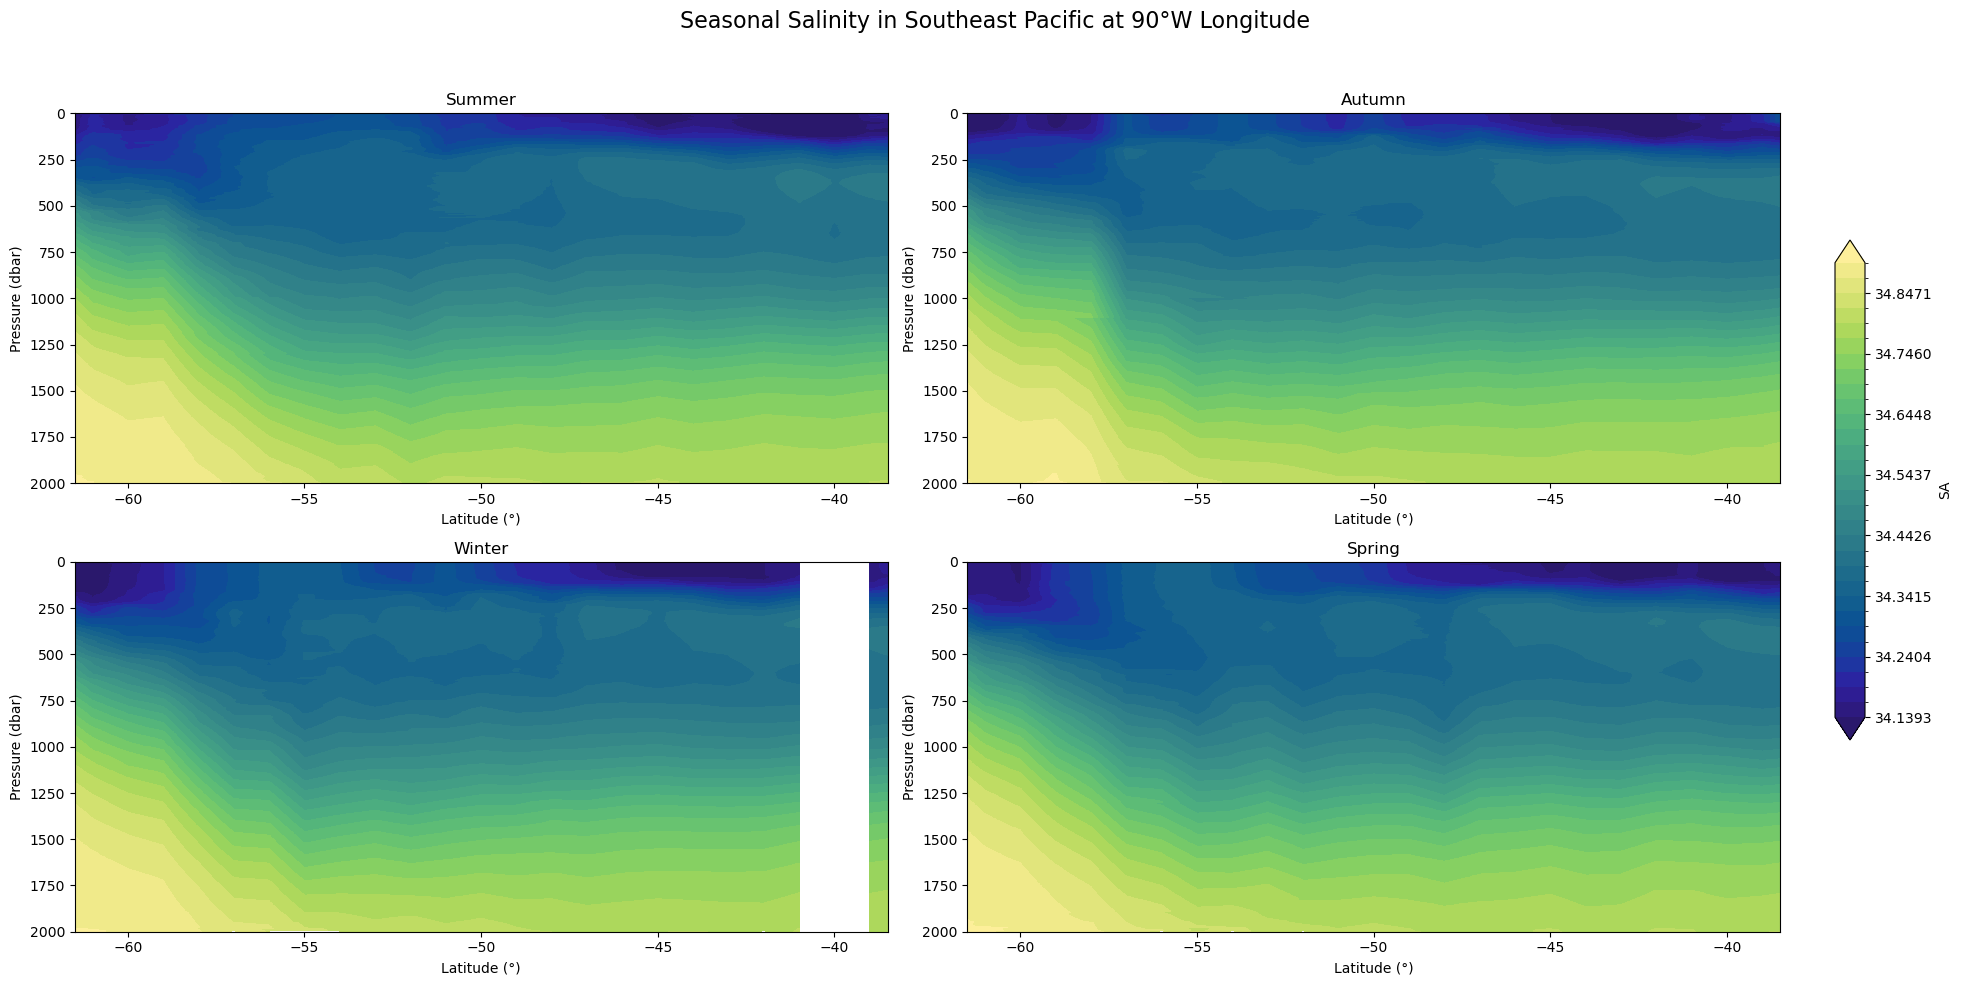

In [87]:
# Clip and prepare anomalies
seasonal_SA_sections = {
    season: ds.SA.sel(lat_c=slice(-65, -38), PRES_INTERPOLATED=slice(0, 2000))
    for season, ds in southpac_seasonal_binned.items()
}

# Get global vmin/vmax for consistent color scale
all_SA = xr.concat([da for da in seasonal_SA_sections.values()], dim='season')
vmin = float(all_SA.quantile(0.02))
vmax = float(all_SA.quantile(0.98))
levels = np.linspace(vmin, vmax, 31)

# Plot
fig, axs = plt.subplots(2, 2, figsize=(20, 10))
axs = axs.ravel()

for i, season in enumerate(ordered_seasons):  # Make sure ordered_seasons is defined like ['DJF', 'MAM', 'JJA', 'SON']
    da = seasonal_SA_sections[season]
    ax = axs[i]
    
    contour = da.plot.contourf(
        ax=ax,
        x='lat_c',
        y='PRES_INTERPOLATED',
        yincrease=False,
        cmap=cmo.haline,
        vmin=vmin,
        vmax=vmax,
        levels=31,
        add_colorbar=False
    )
    
    ax.axvline(0, color='grey', linestyle='--', linewidth=1)
    ax.set_xlim(-61.5, -38.5)
    ax.set_title(season_labels[season])  # make sure season_labels is defined
    ax.set_xlabel("Latitude (°)")
    ax.set_ylabel("Pressure (dbar)")

# Shared colorbar
cbar_ax = fig.add_axes([0.92, 0.25, 0.015, 0.5])
plt.colorbar(contour, cax=cbar_ax, label="SA")

plt.suptitle("Seasonal Salinity in Southeast Pacific at 90°W Longitude", fontsize=16)
plt.tight_layout(rect=[0, 0, 0.9, 0.95])
plt.show()


/tmp/ipykernel_48757/2892565659.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


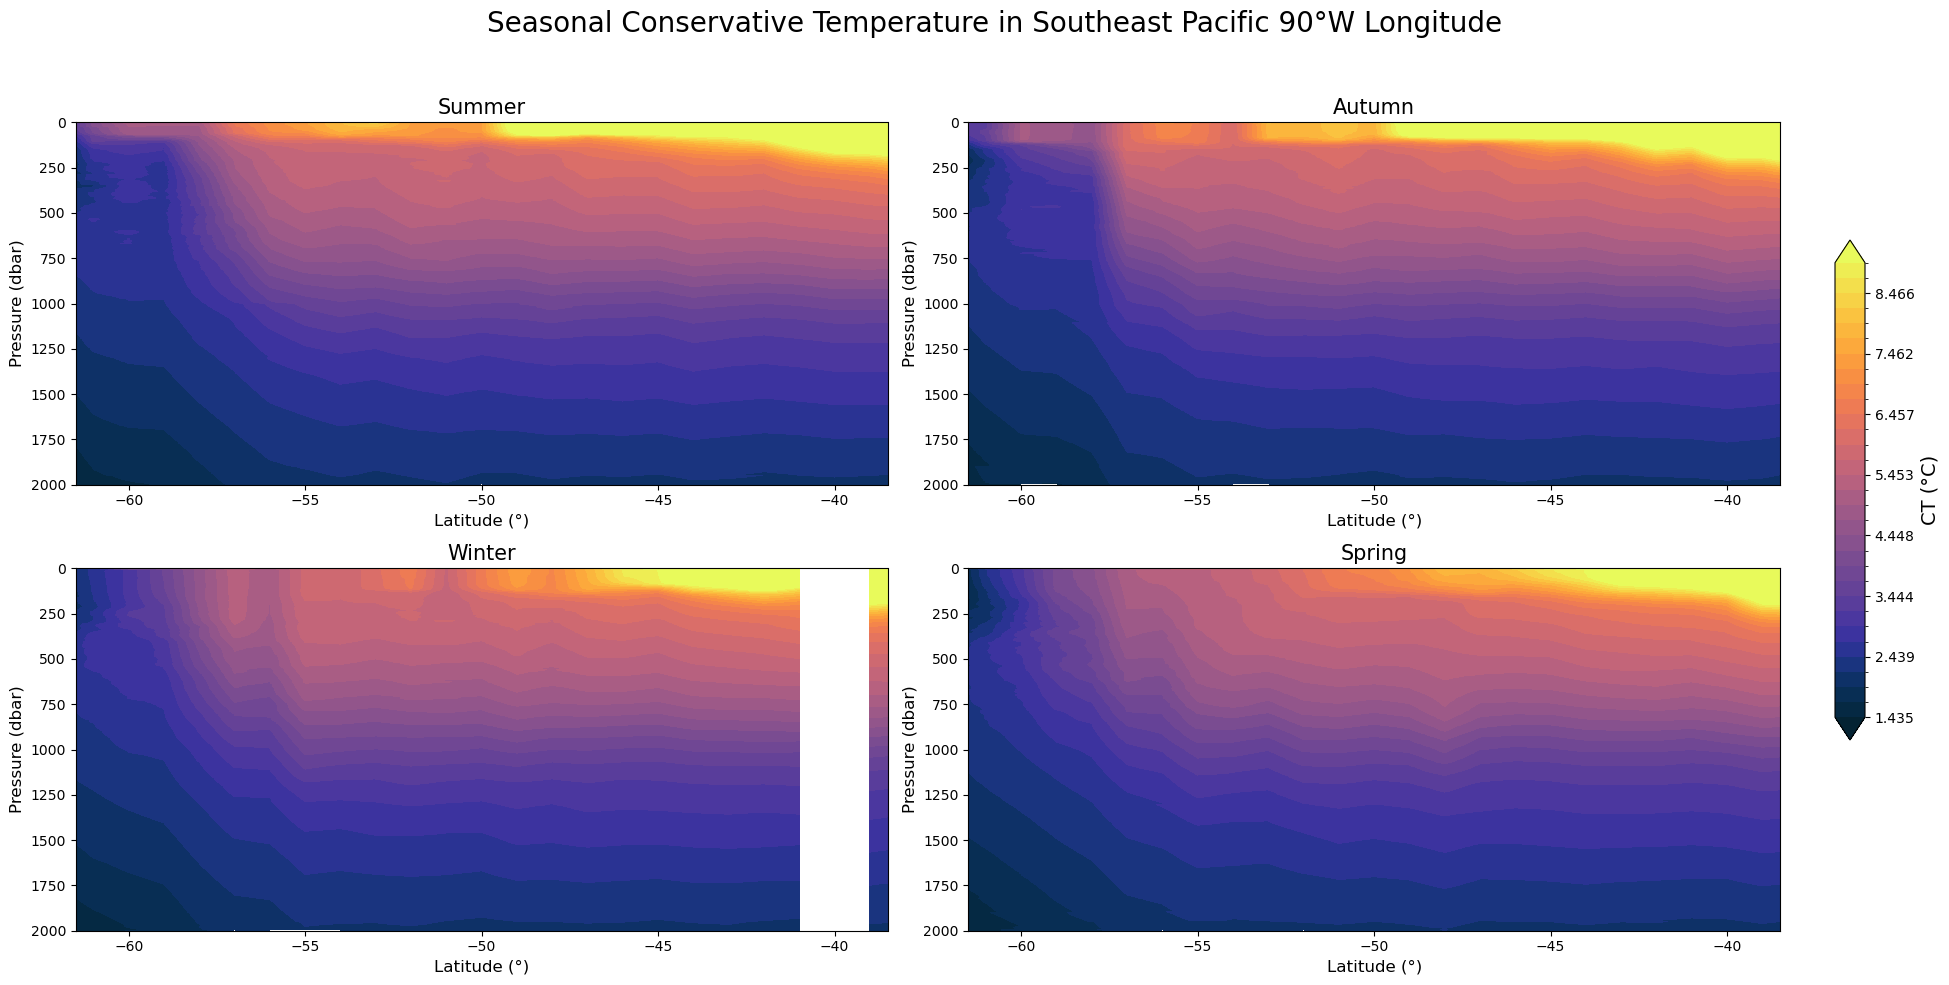

In [90]:
# Clip and prepare anomalies
seasonal_CT_sections = {
    season: ds.CT.sel(lat_c=slice(-65, -38), PRES_INTERPOLATED=slice(0, 2000))
    for season, ds in southpac_seasonal_binned.items()
}

# Get global vmin/vmax for consistent color scale
all_CT = xr.concat([da for da in seasonal_CT_sections.values()], dim='season')
vmin = float(all_CT.quantile(0.02))
vmax = float(all_CT.quantile(0.98))
levels = np.linspace(vmin, vmax, 31)

# Plot
fig, axs = plt.subplots(2, 2, figsize=(20, 10))
axs = axs.ravel()

for i, season in enumerate(ordered_seasons):  # Make sure ordered_seasons is defined like ['DJF', 'MAM', 'JJA', 'SON']
    da = seasonal_CT_sections[season]
    ax = axs[i]
    
    contour = da.plot.contourf(
        ax=ax,
        x='lat_c',
        y='PRES_INTERPOLATED',
        yincrease=False,
        cmap=cmo.thermal,
        vmin=vmin,
        vmax=vmax,
        levels=31,
        add_colorbar=False
    )
    
    ax.axvline(0, color='grey', linestyle='--', linewidth=1)
    ax.set_xlim(-61.5, -38.5)
    ax.set_title(season_labels[season], fontsize = 15)  # make sure season_labels is defined
    ax.set_xlabel("Latitude (°)", fontsize = 12)
    ax.set_ylabel("Pressure (dbar)", fontsize = 12)

# Shared colorbar
cbar_ax = fig.add_axes([0.92, 0.25, 0.015, 0.5])
cbar = plt.colorbar(contour, cax=cbar_ax)
cbar.set_label("CT (°C)", fontsize=14)

plt.suptitle("Seasonal Conservative Temperature in Southeast Pacific 90°W Longitude", fontsize=20)
plt.tight_layout(rect=[0, 0, 0.9, 0.95])
plt.show()
